# Quick Regression

Let's see if we can predict something terribly!

In [96]:
# Bring in data
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Import LinearRegression
from sklearn.linear_model import LinearRegression
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# Split the data
from sklearn.model_selection import train_test_split
# Optimize Parameters
from sklearn.model_selection import RandomizedSearchCV
# Import RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# Import GradientBoosted
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
# Import xgboost
import xgboost as xgb
# Import RSME
from sklearn.metrics import mean_squared_error
from scipy.stats import randint

with open('pitching_data.pickle', 'rb') as file:
    pitcher_data = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_data = pickle.load(file)

In [97]:
# Bring in models
lm = LinearRegression()
logr = LogisticRegression()
rf = RandomForestRegressor()
rfc = RandomForestRegressor()
gbr = GradientBoostingRegressor()
gbc = GradientBoostingClassifier()
xgr = xgb.XGBRegressor()
xgc = xgb.XGBClassifier()

In [98]:
# Create position one-hot configuration
position_data = pd.get_dummies(position_data, columns = ['Position'], prefix= ['Pos'])
pitcher_data = pd.get_dummies(pitcher_data, columns = ['Position'], prefix= ['Pos'])

# Create Contract logical variable
position_data['Contract'] = position_data.Dollars.isnull()
pitcher_data['Contract'] = pitcher_data.Dollars.isnull()

# Remove 2017 data
position_data = position_data[position_data.Year < 2017]
pitcher_data = pitcher_data[pitcher_data.Year < 2017]

position_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 0 to 850
Data columns (total 31 columns):
Age                 851 non-null int64
Destination         851 non-null object
WAR_3               851 non-null float64
nameFirst           851 non-null object
nameLast            851 non-null object
Year                851 non-null int64
Dollars             552 non-null float64
Length              851 non-null int64
playerID            851 non-null object
yearID              851 non-null int64
G                   851 non-null float64
OBP                 851 non-null float64
SLG                 851 non-null float64
HR                  851 non-null float64
RBI                 851 non-null float64
SB                  851 non-null float64
Med_WAR             851 non-null float64
Min_WAR             851 non-null float64
Inflation_Factor    851 non-null float64
Total               851 non-null float64
Dollars_2006        552 non-null float64
Pos_1B              851 non-null uint8
Pos_2B 

In [99]:
# Define function for Dollars
def predictDollars(model, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.1)
    
    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    plt.scatter(y_pred, y_test, color = 'blue')
    plt.xlabel('Predicted Dollars (millions)')
    plt.ylabel('Actual Dollars (millions)')
    plt.title('Prediction Contract Value')
    plt.yticks([0,4e7,8e7,1.2e8,1.6e8],['0','40','80','120','160'])
    plt.xticks([0,2e7,4e7,6e7,8e7,1e8],['0','20','40','60','80','100'])
    plt.text(x = 0, y = 1.5e8, s = "R^2 = {:0.3f}".format(model.score(X_test, y_test)))
    # plt.savefig('./contract_dollars_regression.png')
    plt.show()

    return model

In [100]:
# Definte function for contract length
def predictLength(model, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    plt.scatter(y_pred, y_test, color = 'red')

    plt.xlabel('Predicted Contract Length (years)')

    plt.ylabel('Actual Contract Length (years)')

    plt.title('Prediction Contract Length')
    plt.text(x = 1, y = 7, s = "R^2 = {:0.3f}".format(model.score(X_test, y_test)))
    #plt.savefig('./contract_length_regression.png')
    plt.show()

    return model

# First Task: Predict Yes/No on contract

We'll use a binary classifier (starting with Logistic Regression and moving on if needed) to:

1. Classify position players into "Yes/No" on contract
2. Classify pitchers into "Yes/No" on contract
3. Run RandomizedSearchCV to determine best parameters for each model


## Attempt 1: Batting Data w/ Team WAR

Woo!

### Step 1: Predict which players will get contracts

In [101]:
# Designate interesting columns
features_pos = ['Age', 'WAR_3', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'SB',
                'Med_WAR', 'Min_WAR', 'Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B',
                'Pos_SS', 'Pos_LF', 'Pos_CF', 'Pos_RF', 'Pos_DH']

# For now, simulate dropping these
position_trimmed = position_data.dropna()

### Step 2: Predict how big the contracts will be

Make 2 models, and do it in 2006 dollars

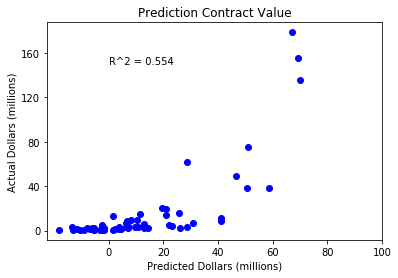

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
# Grab just the features and the outcome
X_pos = position_trimmed[features_pos].values
y_dollars_pos = position_trimmed['Dollars_2006'].values
y_dollars_raw_pos = position_trimmed['Dollars'].values
y_length_pos = position_trimmed['Length'].values
predictDollars(lm, X_pos, y_dollars_pos)

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 8 is present in all training examples.
  str(classes[c]))


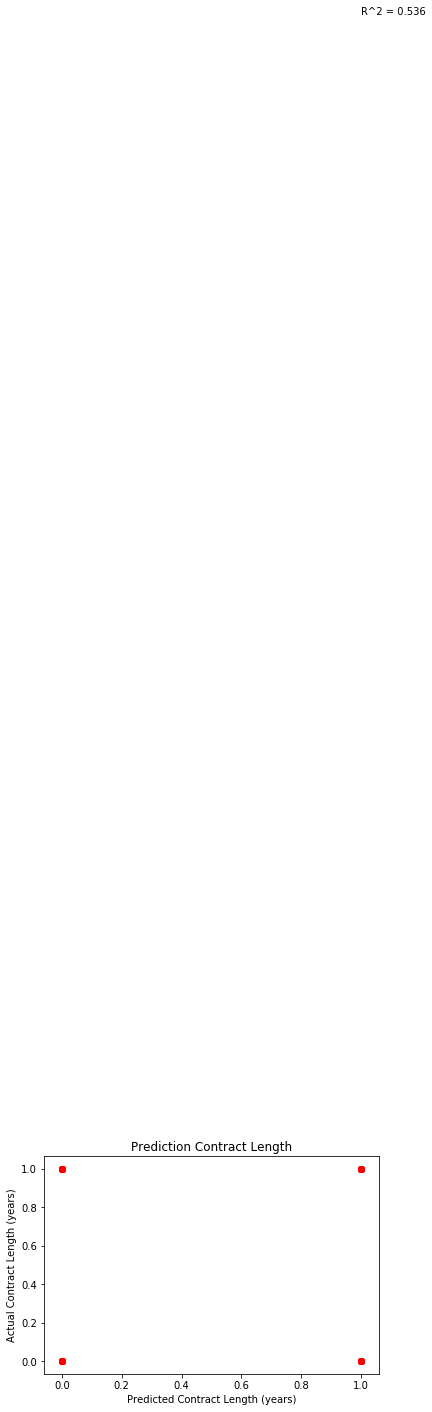

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [103]:
# Do length (This is wrong; need multi-class!)


logr = OneVsRestClassifier(LogisticRegression())

y_dummies  = pd.get_dummies(y_length_pos)

predictLength(logr, X_pos, y_dummies)

## Try Random Forest...now let's add Position to the matrix!

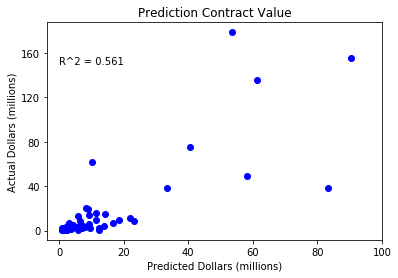

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [104]:
predictDollars(rf, X_pos, y_dollars_pos)

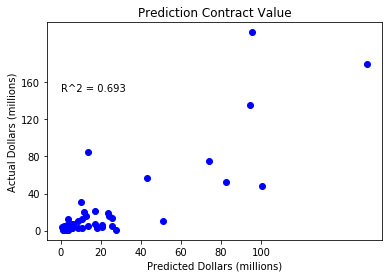

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [105]:
predictDollars(rf, X_pos, y_dollars_raw_pos)

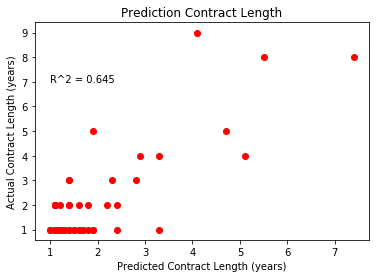

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [106]:
predictLength(rfc, X_pos, y_length_pos)

### Make quadratic terms

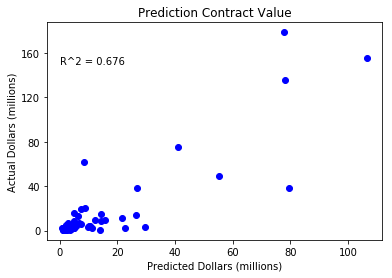

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [107]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
                   
poly = PolynomialFeatures()

something = poly.fit_transform(X_pos)

predictDollars(rf, something, y_dollars_pos)

## Try it for pitchers; straight to RF + LM!

In [108]:
# Designate interesting columns
features_pitch = ['Age', 'WAR_3', 'ERA', 'WHIP', 'K_9', 'HR_9', 'IPouts',
                  'W', 'SV', 'Med_WAR', 'Min_WAR', 'Pos_SP', 'Pos_RP']

# For now, simulate dropping these
pitcher_trimmed = pitcher_data.dropna()

X_pitch = pitcher_trimmed[features_pitch].values
y_dollars_pitch = pitcher_trimmed['Dollars_2006'].values
y_dollars_raw_pitch = pitcher_trimmed['Dollars'].values
y_length_pitch = pitcher_trimmed['Length'].values

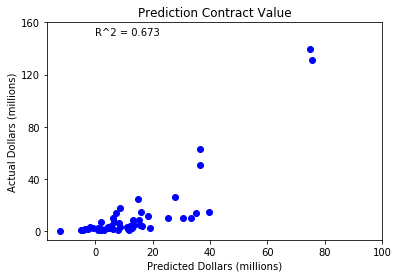

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
# Try the LM
predictDollars(lm, X_pitch, y_dollars_pitch)

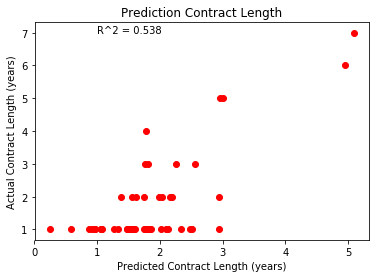

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [110]:
predictLength(lm, X_pitch, y_length_pitch)

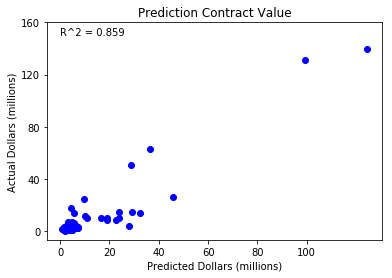

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [111]:
# Try RF
predictDollars(rf, X_pitch, y_dollars_pitch)

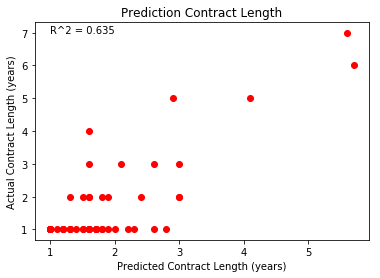

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [112]:
predictLength(rfc, X_pitch, y_length_pitch)

## Try Boosting (xgboost)

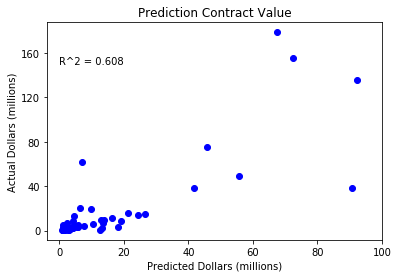

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [113]:
predictDollars(xgr, X_pos, y_dollars_pos)

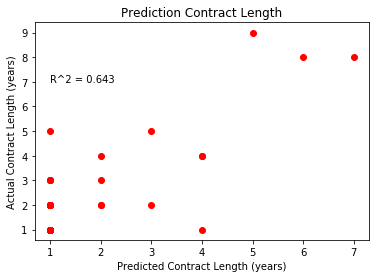

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [114]:
predictLength(xgc, X_pos, y_length_pos)

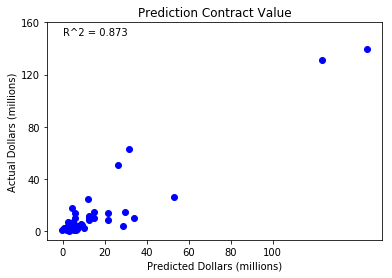

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [115]:
predictDollars(xgr, X_pitch, y_dollars_pitch)

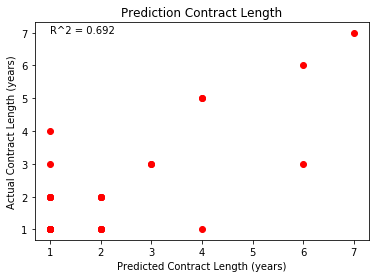

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [116]:
predictLength(xgc, X_pitch, y_length_pitch)

## Try boosting (sklearn)

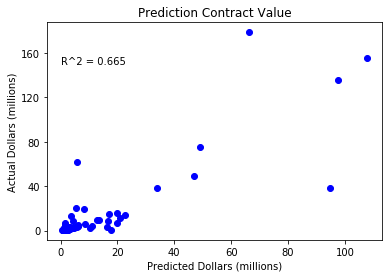

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [117]:
predictDollars(gbr, X_pos, y_dollars_pos)

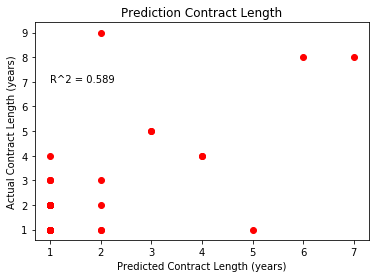

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [118]:
predictLength(gbc, X_pos, y_length_pos)

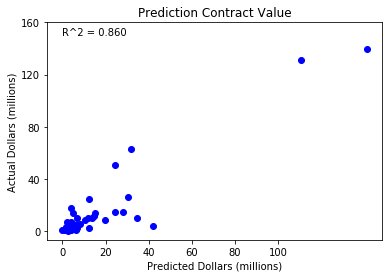

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [119]:
predictDollars(gbr, X_pitch, y_dollars_pitch)

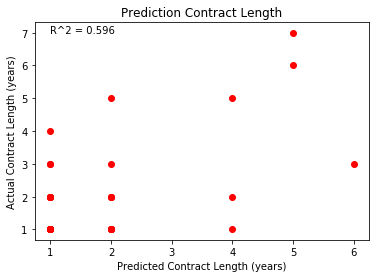

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [120]:
predictLength(gbc, X_pitch, y_length_pitch)

# I'm using GradientBoosted from sklearn....now I must:

1. Determine hyper-parameters using RandomizedSearchCV
2. Pull out feature importance

## 1. Hyper-parameters for position players

In [121]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pos, y_dollars_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1}
Best score is 0.6659102885804612


In [122]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pos, y_length_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}
Best score is 0.5905797101449275


# 2. Hyper-parameters for pitchers

In [123]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pitch, y_dollars_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.001}
Best score is 0.5841510675961938


In [124]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pitch, y_length_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01}
Best score is 0.494140625


## 3. Use correct hyperparameters to train models and pull out feature importance

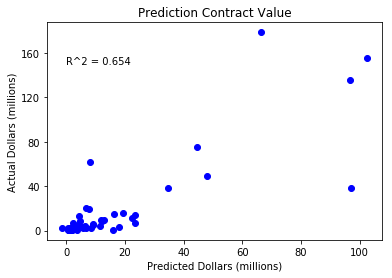

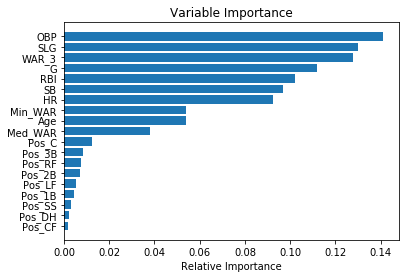

In [129]:
gbr_pos = GradientBoostingRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.1)
gbr_pos_out = predictDollars(gbr_pos, X_pos, y_dollars_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

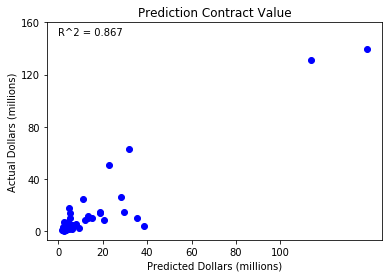

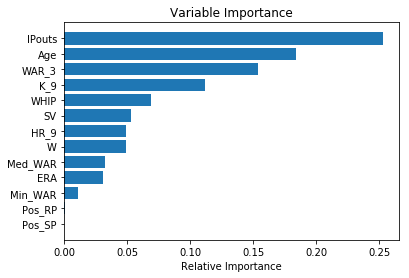

In [132]:
gbr_pitch = GradientBoostingRegressor(max_depth = 3, n_estimators = 5000, learning_rate = 0.001)
gbr_pitch_out = predictDollars(gbr_pitch, X_pitch, y_dollars_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

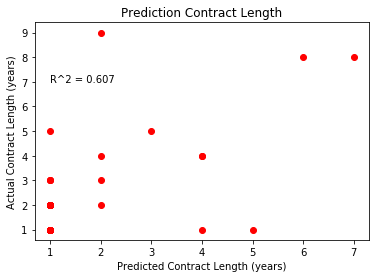

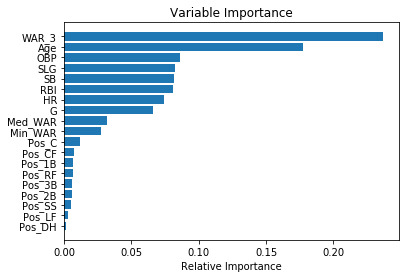

In [130]:
gbc_pos = GradientBoostingClassifier(max_depth = 3, n_estimators = 500, learning_rate = 0.01)
gbc_pos_out = predictLength(gbc_pos, X_pos, y_length_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

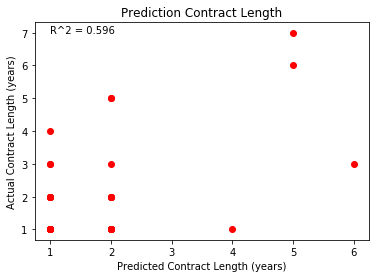

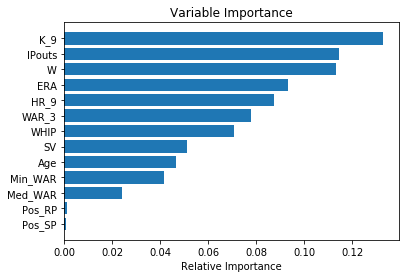

In [133]:
gbc_pitch = GradientBoostingClassifier(max_depth = 5, n_estimators = 1000, learning_rate = 0.01)
gbc_pitch_out = predictLength(gbc_pitch, X_pitch, y_length_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Things the final model should do:

1. Take in a given year
2. Remove that year AND 2017 from the training data
3. For each player in that year, predict:
   1. Whether they will get a major league contract
   2. If "yes", length and total dollars of contract
       1. First, predict in 2006 dollars
       2. Then, grab the inflation table and translate to appropriate year's dollars
   3. If "no", fill in with N/A and 0 (or no major league contract)